# MNIST Fashion classification with dense neural network

Classification on the MNIST Fashion dataset using the Dense (Perceptron) layers as in the Keras tutorial [1]

To compare with the [Convolutional Neural Network implementation](../cnn/CnnMnistFashion-Keras.html) ([Notebook](../cnn/CnnMnistFashion-Keras.ipynb))

Learning goals:
- Evaluate and optimize a neural network
- Use different kinds of regularizers (kernel/bias, dropout, dataset augmentation)

References:
1. [Basic classification - TensorFlow/Keras](https://www.tensorflow.org/tutorials/keras/basic_classification)

In [22]:
import keras
import numpy as np
import matplotlib.pyplot as plt

print(keras.__version__)

# Patch for macOS + Conda distribution of Python
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2.2.4


## Data

Using the fashion MNIST dataset from https://github.com/zalandoresearch/fashion-mnist
It is made of 70k pictures classified in 10 categories. 
Images are greyscale, 28x28 pixels. The train/test split is 60/10.

For more details on the data loading and inspection, see the original Keras tutorial.


In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_width = 28
image_height = 28
n_classes = len(class_names)

batch_size = 128

In [4]:
train_images.shape

(60000, 28, 28)

Scaling the 8 bit pixels of the images to float values in [0,1)

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Helpers

In [6]:
def plot_history(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'])
    if with_validation:
        plt.plot(hist.history['val_loss'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Loss')
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'])
    if with_validation:
        plt.plot(hist.history['val_acc'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Accuracy');

## Classical model based on Dense layers

https://www.tensorflow.org/tutorials/keras/basic_classification

- Images are first flattened to 1D vectors of length 28*28 = 784, loosing the 2D information
- The second layer is based on 128 neurons with 784 inputs, that is 100480 coefficients including the intercepts (bias)
- Last layer is classifying on the 10 categories

In [7]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(image_width, image_height)),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dense(n_classes, activation=keras.activations.softmax)
], 'model1')

model1.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model1.summary()

W0819 15:59:12.061332 4579943872 deprecation.py:506] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist1 = model1.fit(train_images, train_labels, epochs=25, validation_split=0.2, batch_size=batch_size, verbose=0)

Final train accuracy: 0.935


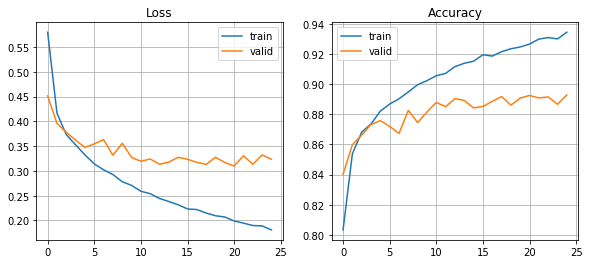

In [9]:
plot_history(hist1, True)
print('Final train accuracy: {:.3f}'.format(hist1.history['acc'][-1]))

In [10]:
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f} accuracy: {:.3f}'.format(test_loss1, test_acc1))
#predictions1 = model1.predict(test_images)

Test loss: 0.356 accuracy: 0.882


As observed in the original Keras tutorial, the accuracy in validation is lower than the one in training.

Given the high number of coefficients (> 100k) compared to the number of train and test samples, this overfitting is expected.

## Adding kernel and bias regularizers

See also: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [11]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(image_width, image_height)), 
    keras.layers.Dense(128, activation=keras.activations.relu,
                       bias_regularizer=keras.regularizers.l1(0.00001),    # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Dense(n_classes, activation=keras.activations.softmax)
], 'model2')

model2.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

hist2 = model2.fit(train_images, train_labels, epochs=25, validation_split=0.2, batch_size=batch_size, verbose=0)

Final train accuracy: 0.928


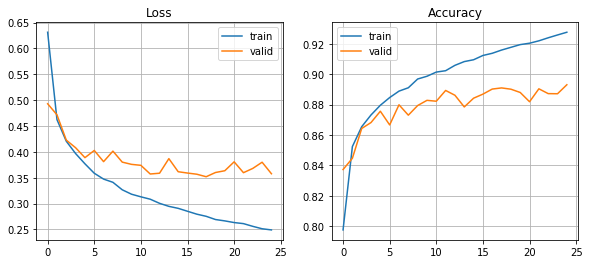

In [12]:
plot_history(hist2, True)
print('Final train accuracy: {:.3f}'.format(hist2.history['acc'][-1]))

In [13]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss2, test_acc2))

Test loss: 0.389, accuracy: 0.882


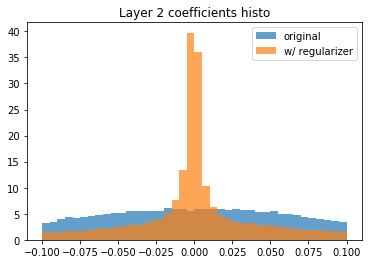

In [14]:
plt.hist(model1.get_weights()[0].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.7);
plt.hist(model2.get_weights()[0].reshape(-1), bins=40, range=(-0.1, 0.1), density=True, alpha=0.7);
plt.title('Layer 2 coefficients histo')
plt.legend(('original', 'w/ regularizer'));

The effect of the regularizer is clearly visible on the coefficients distribution.

It has a small effect on the accurracy in lowering a little the test prediction. Increasing the regularization effect would lower more the accuracies (train, valid and test)


We might then think that the Dense layer of 784 x 128 is overdimensionned

## Optimizing the number of neurons in the Dense layer #2

In [15]:
hist3 = []
for n_neurons in [4, 16, 48, 64, 96, 128, 256]:
    model3 = keras.Sequential([
        keras.layers.Flatten(input_shape=(image_width, image_height)), 
        keras.layers.Dense(n_neurons, activation=keras.activations.relu,      # <---
                           bias_regularizer=keras.regularizers.l1(0.00001),    # <---
                           kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ])

    model3.compile(optimizer='adam',
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

    h = model3.fit(train_images, train_labels, epochs=10, verbose=0)  # <--- Only 10 epochs in this loop
    hist3.append(h)
    print('Final train accuracy for size {:d}: {:.3f}'.format(n_neurons, h.history['acc'][-1]))

Final train accuracy for size 4: 0.828
Final train accuracy for size 16: 0.871
Final train accuracy for size 48: 0.895
Final train accuracy for size 64: 0.899
Final train accuracy for size 96: 0.904
Final train accuracy for size 128: 0.903
Final train accuracy for size 256: 0.904


## Model with 48 neurons

As shown above, the original model with 128 neurons is behaving as good as the one with 48 neurons

In [16]:
model4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(image_width, image_height)), 
    keras.layers.Dense(48, activation=keras.activations.relu,             # <---
                       bias_regularizer=keras.regularizers.l1(0.00001),    # <---
                       kernel_regularizer=keras.regularizers.l1(0.00001)), # <---
    keras.layers.Dense(n_classes, activation=keras.activations.softmax)
], name='model4')

model4.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model4.summary()

hist4 = model4.fit(train_images, train_labels, epochs=25, validation_split=0.2, batch_size=batch_size, verbose=0)

Model: "model4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 48)                37680     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                490       
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________


Final train accuracy: 0.914


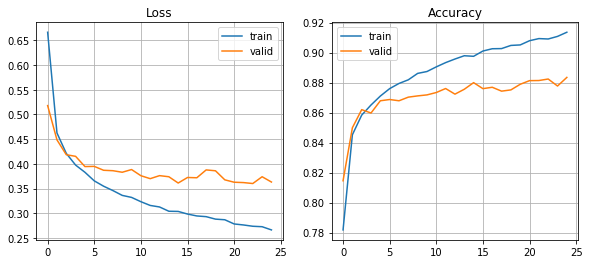

In [17]:
plot_history(hist4, True)
print('Final train accuracy: {:.3f}'.format(hist4.history['acc'][-1]))

In [18]:
test_loss4, test_acc4 = model4.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss4, test_acc4))

Test loss: 0.383, accuracy: 0.877


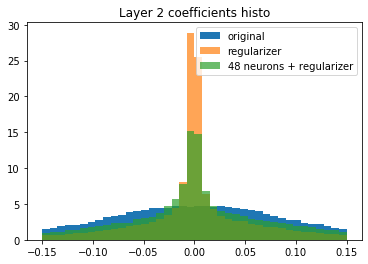

In [19]:
plt.hist(model1.get_weights()[0].reshape(-1), bins=40, range=(-0.15, 0.15), density=True);
plt.hist(model2.get_weights()[0].reshape(-1), bins=40, range=(-0.15, 0.15), density=True, alpha=0.7);
plt.hist(model4.get_weights()[0].reshape(-1), bins=40, range=(-0.15, 0.15), density=True, alpha=0.7);
plt.title('Layer 2 coefficients histo')
plt.legend(('original', 'regularizer', '48 neurons + regularizer'));

With 48 neurons, the test performance is quasi identical to the original model but with 1/3 of the number of coefficients. Moreover, the overfitting is decreased, i.e. difference between train and valid/test accuracies is lower. This is expected by the lower number of parameters versus the train data set size